In [1]:
%load_ext autoreload
%autoreload 2
%cd /home/florian/GitRepos/activeCell-ACDC
!ls

import json
import random as rd
import matplotlib.image as mpimg
import cv2
import wandb
import torch
import os
import logging
import pandas as pd
import collections
import matplotlib.pyplot as plt

from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.checkpoint import DetectionCheckpointer

from src.globals import *
from utils.visualization.show_image import show_image
from utils.register_datasets import register_datasets, get_dataset_name
from utils.config_builder import get_config
from utils.notebook_utils import *


from src.test import do_test
from src.active_learning.al_trainer import *
from src.active_learning.mc_dropout_sampler import *


logger = setup_logger(output="./log/main.log",name="null_logger") 
logger.addHandler(logging.NullHandler())
logging.getLogger('detectron2').setLevel(logging.WARNING)
logging.getLogger('detectron2').addHandler(logging.NullHandler())

/home/florian/GitRepos/activeCell-ACDC
ac_acdc_env  local	output		  requirements.txt  utils
al_output    log	pipeline_configs  shell_scripts     wandb
data	     notebooks	README.md	  src


## Initialization

In [2]:
dataset = ACDC_LARGE
config_name = "acdc_large_al"

model_path = "/home/florian/GitRepos/activeCell-ACDC/al_output/acdc_large_al/random/best_model5.pth"


In [3]:
register_datasets()
train_data = DatasetCatalog.get(get_dataset_name(
    dataset, DATASETS_DSPLITS[dataset][0]
))

test_data = DatasetCatalog.get(get_dataset_name(
    dataset, DATASETS_DSPLITS[dataset][1]
))

registering acdc_small dataset
registering acdc_large dataset
registering acdc_large_cls dataset


In [4]:
wandb.init(
    project="activeCell-ACDC",
    name="",
    sync_tensorboard=True,
    mode="disabled",
)

In [5]:
default_cfg = get_config(config_name)
cfg = default_cfg
cfg.OUTPUT_DIR = "./al_output/acdc_large_al"
cfg.AL.OBJECT_TO_IMG_AGG = "mean"

## Initialize Uncertainty Methods

In [13]:
query_strategy = MCDropoutSampler(cfg)
model = load_model(cfg, model_path)
model = patch_module(model)


rd.seed(1337)
sample_data = rd.sample(train_data, 10)


In [14]:
def val2dicts(val):

    preds = []
    for v in val:
        pred_masks = v["pred_masks"].detach().cpu().numpy()
        pred_classes = v["pred_classes"].detach().cpu().numpy()

        preds.append({
            "pred_masks": pred_masks,
            "pred_classes": pred_classes,
        })

    return preds

def get_uncertainties(im_json, model, query_strategy):

    im = query_strategy.load_image(im_json)
    instance_list = query_strategy.get_mc_dropout_samples(model, im, cfg.AL.NUM_MC_SAMPLES)
    combinded_instances = query_strategy.get_combinded_instances(instance_list)


    height, width = im.shape[:2]
    uncertainties = []

    for key, val in combinded_instances.items():

        val_len = torch.tensor(len(val)).to("cuda")

        if query_strategy.cfg.MODEL.ROI_HEADS.NUM_CLASSES > 1:
            u_sem = query_strategy.get_semantic_uncertainty(val, device = "cuda").detach().cpu().numpy()
        else:
            u_sem = 0
        u_mask = query_strategy.get_mask_uncertainty(val, height, width, val_len, device="cuda").detach().cpu().numpy()
        u_box = query_strategy.get_box_uncertainty(val, val_len, device="cuda").detach().cpu().numpy()
        u_det = query_strategy.get_detection_uncertainty(cfg.AL.NUM_MC_SAMPLES, val_len, device="cuda").detach().cpu().numpy()
        
        

        cpu_val = val2dicts(val)

        uncertainties.append({
            "val": cpu_val,
            "u_sem": u_sem,
            "u_mask": u_mask,
            "u_box": u_box,
            "u_det": u_det,

        })


    
    return uncertainties





    

acdc_data3_Yagya_SCGE_WT_pos_4_19


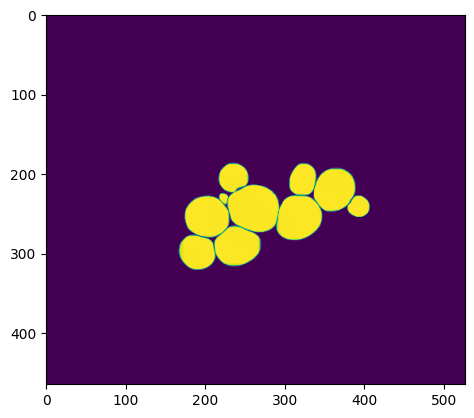

number of detections 40 u_sem 0 u_mask 0.9742481 u_box 0.95103323 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.97203004 u_box 0.94801104 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9738697 u_box 0.96357286 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9665162 u_box 0.9342402 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9703352 u_box 0.95174474 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9685863 u_box 0.9326501 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.96720505 u_box 0.94982463 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9674671 u_box 0.9471286 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9625967 u_box 0.9467989 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.93343544 u_box 0.8975992 u_det 1.0
acdc_data3_Yagya_SCD_WT_pos_4_8


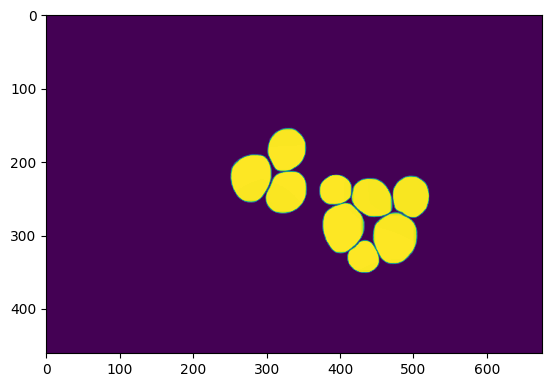

number of detections 40 u_sem 0 u_mask 0.9685961 u_box 0.950576 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9664794 u_box 0.9447333 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9705988 u_box 0.9371912 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9734372 u_box 0.9417547 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.97281444 u_box 0.95655984 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9716417 u_box 0.95120686 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9709717 u_box 0.9538204 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9695469 u_box 0.94914645 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9720739 u_box 0.9372097 u_det 1.0
acdc_data3_20210722_pos_17_42


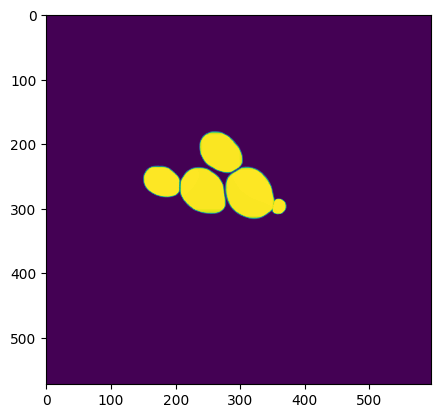

number of detections 40 u_sem 0 u_mask 0.9659584 u_box 0.94208544 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9704107 u_box 0.9509717 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.96746504 u_box 0.9353689 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.96269166 u_box 0.9407134 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9540266 u_box 0.93078154 u_det 1.0
acdc_data3_Yagya_SCGE_WT_pos_2_141


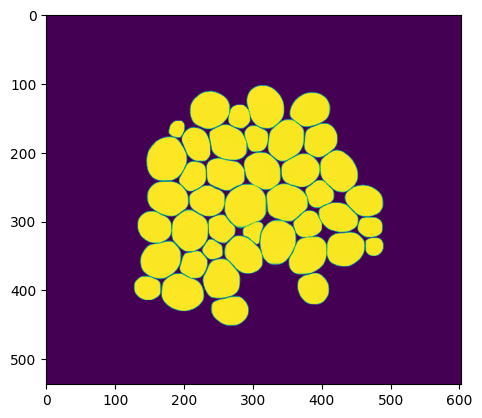

number of detections 40 u_sem 0 u_mask 0.9735425 u_box 0.955931 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9723328 u_box 0.9512103 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.96880054 u_box 0.9631093 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9772229 u_box 0.9664017 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.97217715 u_box 0.9744652 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.96884954 u_box 0.9502988 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.97204435 u_box 0.9589556 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9750069 u_box 0.9628582 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9767536 u_box 0.96561563 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9725665 u_box 0.96319854 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.97072256 u_box 0.9601177 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9734419 u_box 0.96617997 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.97284997 u_box 0.9676548 u_det 1.0
number of detecti

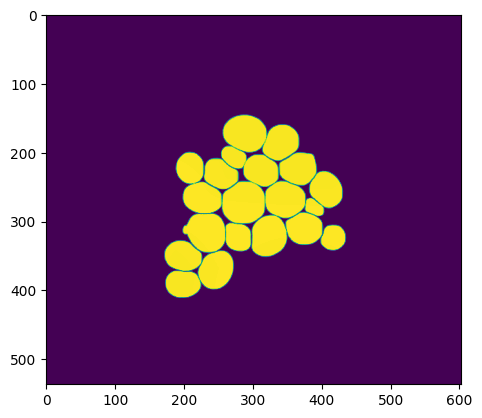

number of detections 40 u_sem 0 u_mask 0.97534496 u_box 0.95730066 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9744953 u_box 0.96701 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9701821 u_box 0.96195126 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9727751 u_box 0.951358 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9717391 u_box 0.94172573 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9716791 u_box 0.95693094 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9719656 u_box 0.95930374 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9732951 u_box 0.9553787 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.97500867 u_box 0.961013 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.96741354 u_box 0.9458214 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9716299 u_box 0.9596826 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9704007 u_box 0.96328866 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.97308767 u_box 0.9530136 u_det 1.0
number of detection

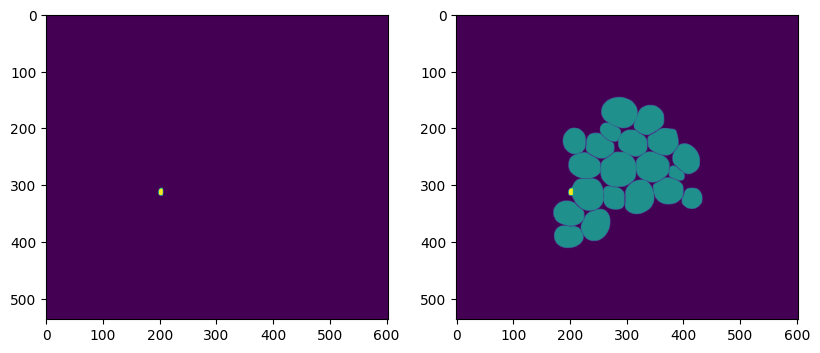

TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_8_24


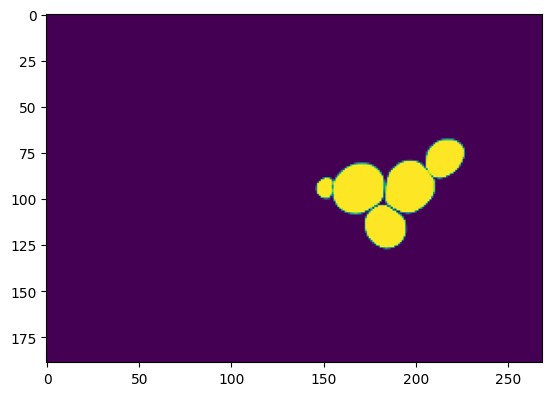

number of detections 40 u_sem 0 u_mask 0.96417177 u_box 0.9476172 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.970461 u_box 0.94102764 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.96111506 u_box 0.9360282 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.97238827 u_box 0.9563955 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.92184544 u_box 0.92556363 u_det 1.0
acdc_data2_kurt_306-3_20_20201105_pos_5_81


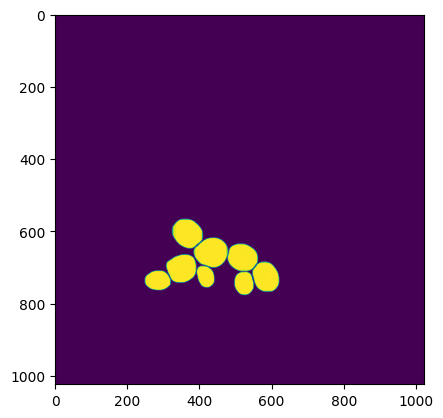

number of detections 40 u_sem 0 u_mask 0.9675701 u_box 0.94688034 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9637536 u_box 0.9396145 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9686505 u_box 0.9390232 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9695753 u_box 0.94545364 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.97048074 u_box 0.95607865 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.96409017 u_box 0.94758034 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.96751916 u_box 0.95619977 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9660357 u_box 0.9501728 u_det 1.0
acdc_data3_20210722_pos_1_173


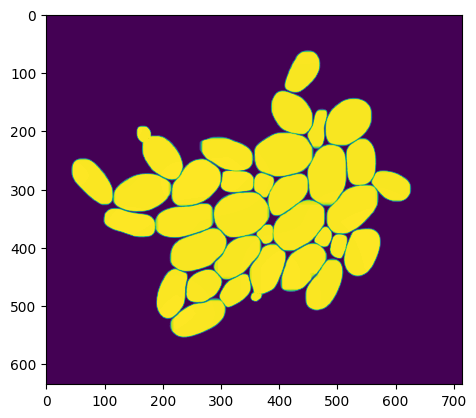

number of detections 40 u_sem 0 u_mask 0.9735125 u_box 0.9600574 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.96882284 u_box 0.9581741 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9700681 u_box 0.9496832 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9682833 u_box 0.9480833 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9734875 u_box 0.97010124 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.97195065 u_box 0.9641504 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.96748257 u_box 0.9575311 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9719397 u_box 0.96150935 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.97177136 u_box 0.95209646 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.97202843 u_box 0.9568906 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9712076 u_box 0.9630663 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9722084 u_box 0.95364237 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9725323 u_box 0.9674257 u_det 1.0
number of detect

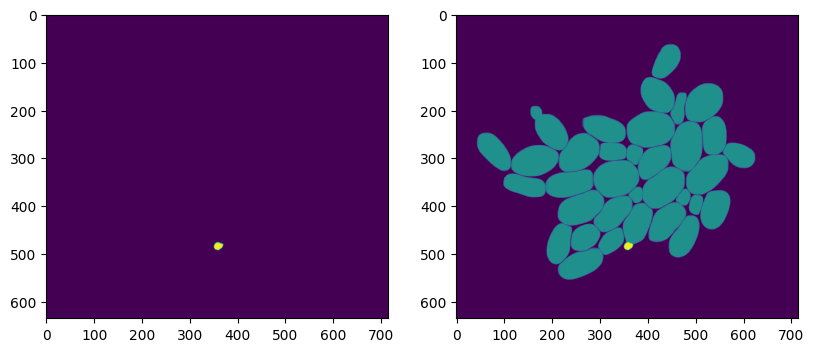

number of detections 40 u_sem 0 u_mask 0.951795 u_box 0.93457377 u_det 1.0
acdc_data3_Yagya_SCGE_WT_pos_5_144


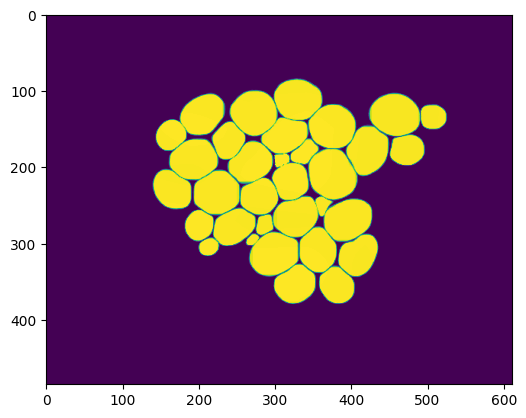

number of detections 40 u_sem 0 u_mask 0.9682587 u_box 0.95545423 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9735538 u_box 0.95941705 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9685591 u_box 0.95799285 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9686629 u_box 0.9535955 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.973307 u_box 0.96532315 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9735364 u_box 0.9643133 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9650122 u_box 0.9535667 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9711979 u_box 0.95628357 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9695076 u_box 0.94476116 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9702444 u_box 0.94129574 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.97054416 u_box 0.9484846 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9697177 u_box 0.95384896 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.96611136 u_box 0.93844116 u_det 1.0
number of detec

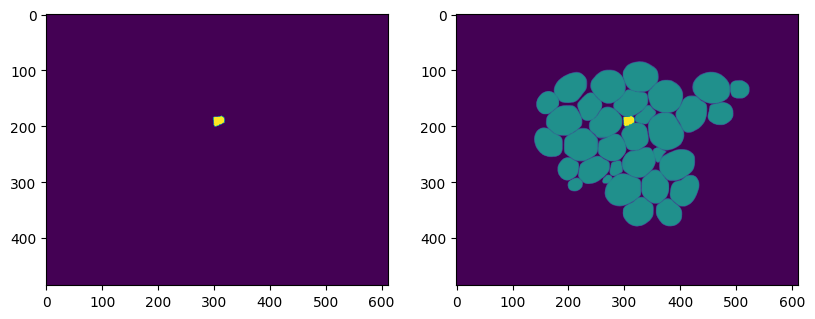

acdc_data3_20210722_pos_17_177


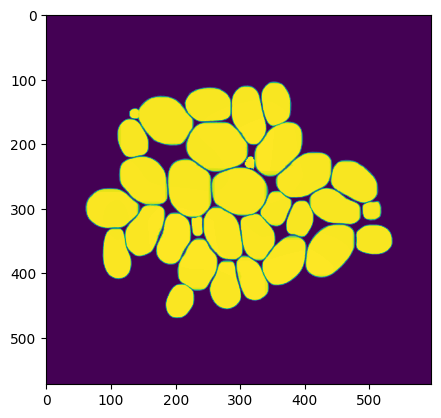

number of detections 40 u_sem 0 u_mask 0.9665257 u_box 0.9485367 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9709945 u_box 0.9525881 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.97067755 u_box 0.9573097 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9689228 u_box 0.93686706 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.97095764 u_box 0.95915544 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9692394 u_box 0.954426 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.965999 u_box 0.9456638 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.96887493 u_box 0.9543063 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.9683212 u_box 0.96053714 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.96786755 u_box 0.9535178 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.97084653 u_box 0.9579527 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.96719587 u_box 0.9387018 u_det 1.0
number of detections 40 u_sem 0 u_mask 0.97181195 u_box 0.9622814 u_det 1.0
number of detecti

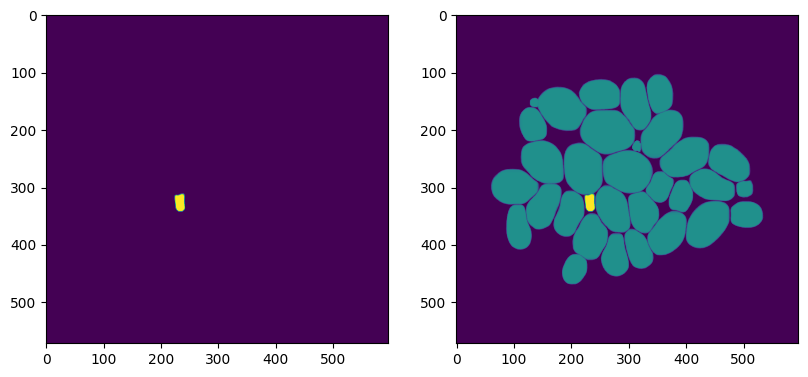

number of detections 1 u_sem 0 u_mask 1.0 u_box 1.0 u_det 0.025


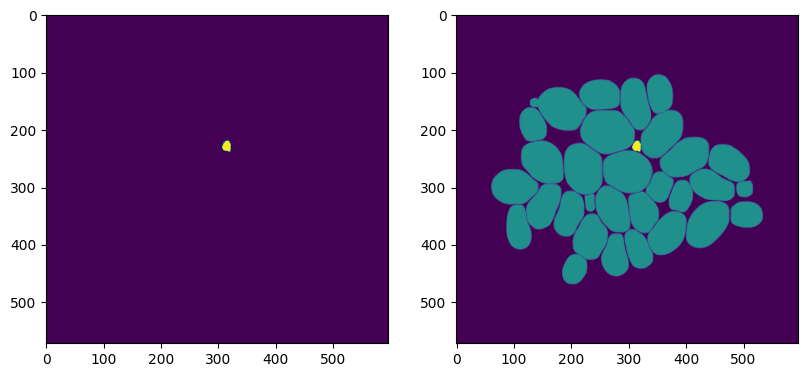

In [18]:

def show_uncertainties(im_json, model, query_strategy):
    print(im_json["image_id"])
    uncertainties = get_uncertainties(im_json, model, query_strategy)

    total_pred_mask = np.max(np.stack([np.mean(np.stack([val["pred_masks"] for val in uncertainty["val"]]), axis=0) for uncertainty in uncertainties]), axis = 0)

    show_image(total_pred_mask)
    for uncertainty in uncertainties:

        print("number of detections", len(uncertainty["val"]), "u_sem", uncertainty["u_sem"], "u_mask", uncertainty["u_mask"], "u_box", uncertainty["u_box"], "u_det", uncertainty["u_det"])

        if uncertainty["u_det"] < 1:
            mask = np.mean(np.stack([val["pred_masks"] for val in uncertainty["val"]]), axis=0)
            show_image([mask, total_pred_mask + mask], normalize=False)



for im_json in sample_data:
    show_uncertainties(im_json, model, query_strategy)